# Dask

## Computación distribuida en Python _à la Spark_

<img src="img/dask.svg" width="300px" />

### Juan Luis Cano Rodríguez <hello@juanlu.space>
### Mission Planning & Execution Engineer @ Satellogic
### PyData Alicante 2019-12-16 @ CubeCut Software

# ¿Quién soy yo?

<img src="img/yo.jpg" style="margin: inherit auto;" width="400px" />

* **Ingeniero Aeronáutico** y pythonista autodidacta
* **Mission Planning & Execution Engineer** en **Satellogic**
* **Presidente de la Asociación Python España 🐍 🇪🇸**
* **Colaborador** en proyectos de **Python Científico**: NumPy, SciPy, conda, astropy, memory-profiler...
* **Profesor asociado** en el **Instituto Empresa** de Python para Big Data
* Amante de la pizza y el hard rock 🤘

# Resumen

<ol>
<li>Estado de la cuestión</li>
<li>Dask
<ol>
  <li>Introducción</li>
  <li>Evaluación perezosa</li>
  <li>Grafos de operaciones</li>
  <li>Demo</li>
  <li>Limitaciones</li>
</ol></li>
<li>Proyectos relacionados</li>
<li>Conclusiones y futuro</li>
</ol>

## _¿El principio del fin de PySpark?_

# 1. Estado de la cuestión

**Vuestro portátil: ~3.6 GHz**

![Clock speed](img/clock.jpg)

https://en.wikipedia.org/wiki/File:Clock_CPU_Scaling.jpg

![Big Data](img/bigdata.png)

<img src="img/cpus.gif" style="margin: inherit auto;" />

# 2. Dask

dask es una biblioteca de computación paralela orientada a la analítica. Está formada por dos componentes:

<img src="img/dask.svg" width="300px" />

1. _Dynamic task scheduling_ optimizada para la computación.
2. Colecciones "Big Data" como arrays, DataFrames y listas paralelas, que mimetizan la forma de trabajar con NumPy, pandas o iteradores de Python para objetos más grandes que la memoria disponible o en entornos distribuidos. Estas colecciones funcionan sobre los _schedulers_.

Es un proyecto joven pero tiene determinadas propiedades que lo hacen muy interesante, entre ellas:

* **Familiar**: Dask replica la forma de trabajar con arrays de Numpy y DataFrames de pandas, así que la transición es mucho más sencilla que con otros sistemas.
* **Flexible**: Se integra bien con otros proyectos y provee herramientas para paralelizar nuestras propias funciones.
* **Nativo**: Es Python puro, no hay antipatrones ni comunicación con otros lenguajes.
* **Escalable**: Dask funciona tanto en clusters de 1000 nodos como en portátiles normales, optimizando el uso de memoria.
* **Amistoso**: Proporciona feedback inmediato y abundantes herramientas de diagnóstico.

![dask](img/collections-schedulers.png)

## Instalación

La versión más reciente es la 2.9.0 (2019-12-06, ¡hace unos días!) y se puede instalar con pip:

```
$ pip install dask[complete]
```

o con conda:

```
$ conda install dask
```

## Evaluación perezosa

Vamos a hacer un ejemplo trivial con `dask.array` para comprobar cómo funciona la computación en dask.

In [1]:
import numpy as np
import dask.array as da

In [2]:
x = np.arange(1000)
y = da.from_array(x, chunks=100)

In [3]:
y

dask.array<array, shape=(1000,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>

Si intentamos efectuar cualquier operación sobre estos arrays, no se ejecuta inmediatamente:

In [4]:
op = y.mean()
op

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

Dask en su lugar construye un grafo con todas las operaciones necesarias y sus dependencias para que podamos visualizarlo y razonar sobre él. Este grafo está almacenado en estructuras de datos corrientes de Python como diccionarios, listas y tuplas:

In [5]:
y.dask.dicts

{'array-e30dcabe0f2b3c7236d769ba2cbdb28b': {('array-e30dcabe0f2b3c7236d769ba2cbdb28b',
   0): (<function _operator.getitem(a, b, /)>,
   'array-original-e30dcabe0f2b3c7236d769ba2cbdb28b',
   (slice(0, 100, None),)),
  ('array-e30dcabe0f2b3c7236d769ba2cbdb28b',
   1): (<function _operator.getitem(a, b, /)>, 'array-original-e30dcabe0f2b3c7236d769ba2cbdb28b', (slice(100, 200, None),)),
  ('array-e30dcabe0f2b3c7236d769ba2cbdb28b',
   2): (<function _operator.getitem(a, b, /)>, 'array-original-e30dcabe0f2b3c7236d769ba2cbdb28b', (slice(200, 300, None),)),
  ('array-e30dcabe0f2b3c7236d769ba2cbdb28b',
   3): (<function _operator.getitem(a, b, /)>, 'array-original-e30dcabe0f2b3c7236d769ba2cbdb28b', (slice(300, 400, None),)),
  ('array-e30dcabe0f2b3c7236d769ba2cbdb28b',
   4): (<function _operator.getitem(a, b, /)>, 'array-original-e30dcabe0f2b3c7236d769ba2cbdb28b', (slice(400, 500, None),)),
  ('array-e30dcabe0f2b3c7236d769ba2cbdb28b',
   5): (<function _operator.getitem(a, b, /)>, 'array-origi

In [6]:
op.dask.dicts

{'mean_agg-aggregate-f2f4df75bd5e24989d51d701807bd50b': {('mean_agg-aggregate-f2f4df75bd5e24989d51d701807bd50b',): (functools.partial(<function mean_agg at 0x7f81b83ff4c0>, dtype=dtype('float64'), axis=(0,), keepdims=False),
   [('mean_combine-partial-966a5ccef2c1ae4a1763289b49bd8fe8', 0),
    ('mean_combine-partial-966a5ccef2c1ae4a1763289b49bd8fe8', 1),
    ('mean_combine-partial-966a5ccef2c1ae4a1763289b49bd8fe8', 2)])},
 'mean_combine-partial-966a5ccef2c1ae4a1763289b49bd8fe8': {('mean_combine-partial-966a5ccef2c1ae4a1763289b49bd8fe8',
   0): (functools.partial(<function mean_combine at 0x7f81b83ff430>, axis=(0,), keepdims=True),
   [('mean_chunk-34017827db9ad0848df29f76eadef2b2', 0),
    ('mean_chunk-34017827db9ad0848df29f76eadef2b2', 1),
    ('mean_chunk-34017827db9ad0848df29f76eadef2b2', 2),
    ('mean_chunk-34017827db9ad0848df29f76eadef2b2', 3)]),
  ('mean_combine-partial-966a5ccef2c1ae4a1763289b49bd8fe8',
   1): (functools.partial(<function mean_combine at 0x7f81b83ff430>, axis=(

Y podemos visualizarlo si tenemos instalada la biblioteca graphviz:

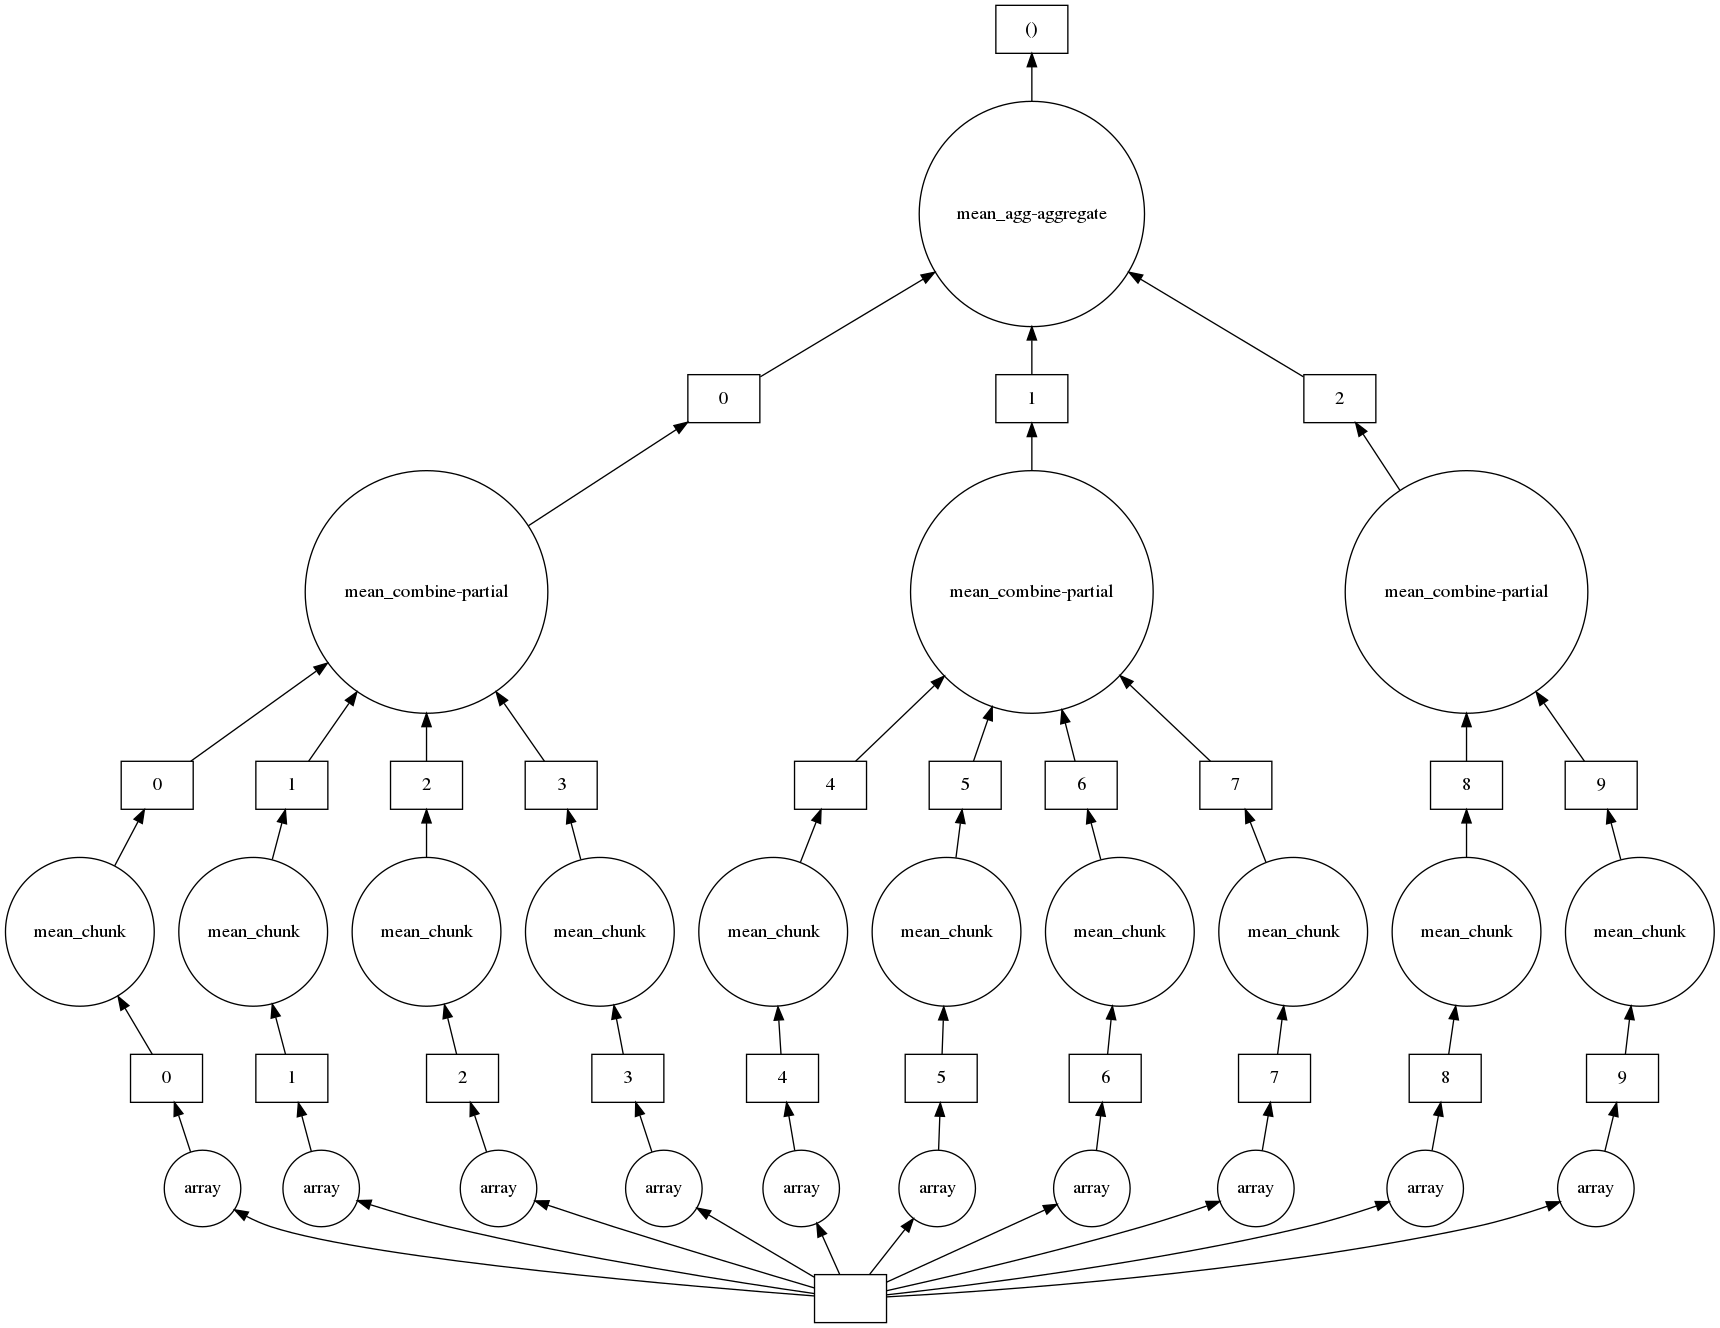

In [7]:
op.visualize()

Si queremos efectuar la operación, tendremos que llamar al método `.compute()`.

In [8]:
op.compute()

499.5

Si queremos convertir nuestro array original a array de NumPy, también se hace llamando a `compute()`:

In [9]:
y.compute()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

## Demo: Taxis de NYC

Otra de las estructuras de datos que provee pandas son los DataFrames, que se comportan de la misma manera que los DataFrames de pandas.

<img src="img/dask-dataframe.svg" width="300px" />

Para estudiar cómo funciona, vamos a descargar datos de trayectos de los taxis de New York:

In [10]:
!cat data/raw_data_urls.txt

https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-01.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-02.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-03.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-04.csv


In [11]:
!du data/yellow*.csv -h -s

656M	data/yellow_tripdata_2019-01.csv
620M	data/yellow_tripdata_2019-02.csv
693M	data/yellow_tripdata_2019-03.csv
658M	data/yellow_tripdata_2019-04.csv


In [12]:
!cat data/download_raw_data.sh

cat raw_data_urls.txt | xargs -n 1 -P 6 wget -c -P .


Tanto `dask.dataframe` como `dask.array` usan un _scheduler_ por defecto basado en hilos. En su lugar, vamos a utilizar una clase `Client`, la que emplearíamos si estuviéramos en un cluster.

In [13]:
import dask.dataframe as dd

In [14]:
from distributed import Client, progress

Esta clase `Client`, cuando se utiliza en local, lanza un scheduler que minimiza el uso de memoria y aprovecha todos los núcleos de la CPU.

> "The dask single-machine schedulers have logic to execute the graph in a way that minimizes memory footprint." http://dask.pydata.org/en/latest/custom-graphs.html?highlight=minimizes%20memory#related-projects

El servidor de diagnóstico está disponible en http://127.0.0.1:8787/.

In [15]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:40041")
client

Client Scheduler: tcp://127.0.0.1:40041 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.73 GB


Y ahora leemos los `.csv` con un filtro todos a la vez en el mismo DataFrame de Dask:

In [16]:
df = dd.read_csv("data/yellow*.csv", parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

Que mimetiza la API de pandas:

In [17]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


In [18]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
dtype: object

Vamos a calcular la longitud del DataFrame:

In [19]:
# Esta operación bloquea el intérprete durante unos minutos
len(df)

29952851

Como se puede observar, el uso de memoria está contenido y todas las CPUs están trabajando.

![len](img/len_df.png)

También lo podemos hacer de manera asíncrona:

In [20]:
futures = client.submit(len, df)
futures

<Future: pending, key: len-ba53e73bd851b9acbce1db3147916a2f>

In [21]:
# Doesn't work, see https://github.com/dask/distributed/issues/3324
# progress(futures)

Vamos ahora a calcular la distancia media recorrida en función del número de ocupantes. Igual que cuando usábamos `dask.array`, la operación no se efectúa automáticamente.

In [22]:
op = df.groupby(df.passenger_count).trip_distance.mean()
op

Dask Series Structure:
npartitions=1
    float64
        ...
Name: trip_distance, dtype: float64
Dask Name: truediv, 240 tasks

In [23]:
f2 = client.compute(op)
f2

<Future: pending, key: finalize-f2fcbd32b7961de72012aa4fafe66321>

<div class="alert alert-warning">El método <code>client.compute</code> almacena el resultado en un solo nodo, y por tanto debe usarse con cuidado. Para objetos grandes, es mejor usar <code>client.persist</code>.</div>

En este caso la visualización de la operación ya tiene una magnitud considerable:

In [24]:
op.visualize()

In [25]:
f2.result()

passenger_count
0    2.788861
1    2.894872
2    3.009092
3    2.970344
4    3.015722
5    2.959904
6    2.934012
7    2.186186
8    5.187980
9    3.607727
Name: trip_distance, dtype: float64

Más operaciones que se pueden hacer:

In [26]:
df2 = df[(df.tip_amount > 0) & (df.fare_amount > 0)]    # filter out bad rows
df2['tip_fraction'] = df2.tip_amount / df2.fare_amount  # make new column

In [27]:
hour = df2.groupby(df2.tpep_pickup_datetime.dt.hour).tip_fraction.mean()
hour

Dask Series Structure:
npartitions=1
    float64
        ...
Name: tip_fraction, dtype: float64
Dask Name: truediv, 780 tasks

In [28]:
f_hour = client.compute(hour)

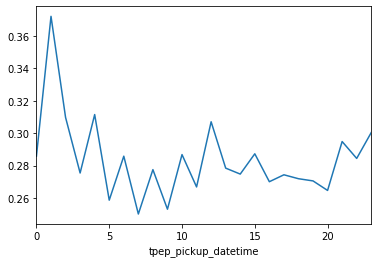

In [31]:
f_hour.result().plot()

In [33]:
import pandas as pd

In [34]:
payments = pd.DataFrame(
    {
        1: 'Credit Card',
        2: 'Cash',
        3: 'No Charge',
        4: 'Dispute',
        5: 'Unknown',
        6: 'Voided trip'
    }, index=["payment_name"]
).T

payments

,payment_name
1,Credit Card
2,Cash
3,No Charge
4,Dispute
5,Unknown
6,Voided trip


In [35]:
df2 = df.merge(payments, left_on='payment_type', right_index=True)

In [36]:
client.compute(df2.groupby(df2.payment_name).tip_amount.mean()).result()

payment_name
Cash           0.000358
Credit Card    2.896196
Dispute       -0.006623
No Charge      0.968446
Unknown        0.000000
Name: tip_amount, dtype: float64

## Limitaciones

No todas las operaciones pueden ejecutarse leyendo parcialmente los datos en memoria.

In [37]:
zero_tip = df2.tip_amount == 0
cash     = df2.payment_name == 'Cash'

client.compute(dd.concat([zero_tip, cash], axis=1).corr()).result()

/home/juanlu/.pyenv/versions/3.8.0/envs/dask38/lib/python3.8/site-packages/dask/dataframe/multi.py:1054: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


,tip_amount,payment_name
tip_amount,1.000000,0.911077
payment_name,0.911077,1.000000


¿Qué significa este warning? En dask, algunas operaciones son sensibles al particionado http://dask.pydata.org/en/latest/dataframe-design.html#partitions así que tendremos que reindexar el DataFrame para que se alineen:

In [38]:
df2.passenger_count.resample('1d').compute()

ValueError: Can only resample dataframes with known divisions
See https://docs.dask.org/en/latest/dataframe-design.html#partitions
for more information.

In [39]:
df2.npartitions

45

In [40]:
df2.divisions

(None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None)

In [41]:
df3 = df2.set_index('tpep_pickup_datetime')

In [42]:
df3.npartitions

45

In [43]:
df3.divisions

(Timestamp('2001-02-02 14:55:07'),
 Timestamp('2019-01-01 16:48:28'),
 Timestamp('2019-01-04 20:22:47'),
 Timestamp('2019-01-07 23:11:40'),
 Timestamp('2019-01-10 19:26:47'),
 Timestamp('2019-01-13 01:03:37'),
 Timestamp('2019-01-15 18:40:15'),
 Timestamp('2019-01-18 11:35:22.885714432'),
 Timestamp('2019-01-21 14:58:21'),
 Timestamp('2019-01-24 08:53:32'),
 Timestamp('2019-01-26 17:59:52'),
 Timestamp('2019-01-29 12:03:09'),
 Timestamp('2019-01-31 22:15:22'),
 Timestamp('2019-02-03 12:23:44'),
 Timestamp('2019-02-06 08:29:23'),
 Timestamp('2019-02-08 19:17:04'),
 Timestamp('2019-02-11 12:23:35.800000'),
 Timestamp('2019-02-14 07:51:50'),
 Timestamp('2019-02-16 21:46:10'),
 Timestamp('2019-02-19 20:59:17'),
 Timestamp('2019-02-22 15:46:26'),
 Timestamp('2019-02-25 17:31:12'),
 Timestamp('2019-02-28 07:21:55.571428608'),
 Timestamp('2019-03-02 17:11:36'),
 Timestamp('2019-03-05 19:08:00.632938240'),
 Timestamp('2019-03-07 23:52:22.154189824'),
 Timestamp('2019-03-10 16:13:53.773808128')

<div class="alert alert-warning">Las operaciones que requieren reordenar el dataset tienen consideraciones de rendimiento especiales y pueden no ser aptas para realizarse en local.

In [44]:
daily_mean = df3.passenger_count.resample('1d').mean()
daily_mean

Dask Series Structure:
npartitions=45
2001-02-02    int64
2019-01-01      ...
              ...  
2019-04-28      ...
2088-01-24      ...
Name: passenger_count, dtype: int64
Dask Name: resample, 1610 tasks

In [45]:
# No ejecutar en local!
#daily_mean.compute().plot()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
Exception in callback multi_future.<locals>.callback(<Task cancell...ient.py:1143>>) at /home/juanlu/.pyenv/versions/3.8.0/envs/dask38/lib/python3.8/site-packages/tornado/gen.py:495
handle: <Handle multi_future.<locals>.callback(<Task cancell...ient.py:1143>>) at /home/juanlu/.pyenv/versions/3.8.0/envs/dask38/lib/python3.8/site-packages/tornado/gen.py:495>
Traceback (most recent call last):
  File "/home/juanlu/.pyenv/versions/3.8.0/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/juanlu/.pyenv/versions/3.8.0/envs/dask38/lib/python3.8/site-packages/tornado/gen.py", line 501, in callback
    result_list.append(f.result())
asyncio.exceptions.CancelledError


# 3. Proyectos relacionados

El ecosistema alrededor de Dask está creciendo a gran velocidad.

* Modelos Lineales Generalizados https://github.com/dask/dask-glm
* Algoritmos de Machine Learning implementados en Dask https://github.com/dask/dask-ml
* Entrenamiento distribuido de XGBoost https://github.com/dask/dask-xgboost
* Computación en tiempo real _à la Flink_ https://github.com/python-streamz/streamz

# 4. Conclusiones

* Dask tiene varias **ventajas**:
  - Trivial de instalar en local
  - Familiar para usuarios de NumPy y pandas
  - Mismo funcionamiento en un cluster
* Y también algunas limitaciones:
  - Proyecto más joven
  - En local hay que tener cuidado (como era obvio)

## Algunos enlaces

  - Documentación https://docs.dask.org/
  - Dask.distributed https://distributed.dask.org/
  - Blog de desarrollo https://blog.dask.org/

<img src="img/mind.gif" style="margin: inherit auto;" width="400px" />
  
# `>>> print(¡Muchas gracias!)`

### hello@juanlu.space